In [2]:
import cv2
import numpy as np
import os
import scipy.io as io
import matplotlib.pyplot as plt
import pickle

# Tensorflow
import tensorflow as tf
from tensorflow import keras
from tensorflow.keras.layers import *
from tensorflow.keras import layers

import random
from tqdm import tqdm

In [3]:
IMG_SIZE=64

In [126]:
def channel_shift(img):
    value1 = random.random()*1.+0.6
    value2 = random.random()*0.5-0.25
    img = img*value1 + value2
    #img[:,:,:][img[:,:,:]>1]  = 1
    #img[:,:,:][img[:,:,:]<0]  = 0
    if random.random() < 1:
        img = np.flip(img,2)
    return img

def rotation(img, mask, angle):
    angle = int(random.uniform(-angle, angle))
    h, w = img.shape[:2]
    M = cv2.getRotationMatrix2D((int(w/2), int(h/2)), angle, 1)
    img = cv2.warpAffine(img, M, (w, h))
    mask = cv2.warpAffine(mask, M, (w, h))
    return img, mask

def flip(img,mask):
    if random.random() < 0.5:
        img = np.flip(img,1)
        mask = np.flip(mask,1)
    return img, mask

def random_rectangles(img):
    for i in range(3):
        x1 = int(random.random()*size-5)
        x2 = int(random.random()*(size-x1))
        y1 = int(random.random()*size-5)
        y2 = int(random.random()*(size-y1))
        if random.random() < 0.5:
            r = random.random()
            g = random.random()
            b = random.random()
            img[y1:y2+y1,x1:x2+x1] = [r,g,b]
        else:
            img[y1:y2+y1,x1:x2+x1] *= random.random()+0.5 + random.random()-0.3
    return img

In [127]:
def get_frames_and_mats(dataset_path, joints_path, activities_to_gen):
    
    movies = []
    mats = []
    
    #for activity_type in tqdm(os.listdir(joints_path)):
    for activity_type in tqdm(activities_to_gen):
        activity_type_path = os.path.join(joints_path,activity_type)
        for concrete_activity in os.listdir(activity_type_path):
            
            concrete_mat_path = os.path.join(activity_type_path,concrete_activity, "joint_positions.mat")
            concrete_video_path = os.path.join(dataset_path,activity_type, concrete_activity+".avi")
            
            capture = cv2.VideoCapture(concrete_video_path)
            ret, frame = capture.read()
            movie = []
            while ret:
                frame = cv2.resize(frame,(IMG_SIZE,IMG_SIZE))
                movie.append(frame)
                ret, frame = capture.read()
            movies.append(movie)
            mat = io.loadmat(concrete_mat_path)
            mats.append(mat)
            
    return np.array(movies), mats


In [134]:
def get_mask(frame, mat,frames_count):
    f_shape = [240,320]

    joint_masks = []
    joint_idx = 0
    joints_number = 15
    
    for joint_idx in range(joints_number):
        
        mask = np.zeros((IMG_SIZE,IMG_SIZE))
        try:
            x = mat["pos_img"][0][joint_idx][int(frames_count*0.85)]
            y = mat["pos_img"][1][joint_idx][int(frames_count*0.85)]
        except:
            x = mat["pos_img"][0][joint_idx][-1]
            y = mat["pos_img"][1][joint_idx][-1]
        
        x = int(x/(f_shape[1]/IMG_SIZE))
        y = int(y/(f_shape[0]/IMG_SIZE))
        color = (255,255,255)
        mask = cv2.circle(mask,(x,y),7,color, -1)
        joint_masks.append(mask/255.)

        
    joint_masks = np.array(joint_masks)
    joint_masks = np.swapaxes(joint_masks, 0,-1)
    joint_masks = np.swapaxes(joint_masks, 0,1)
            
    return joint_masks

In [135]:
def data_generator(movies, mats, augmentation = False):
    movies_number = len(movies)
    print("movies_number", movies_number)
    while True:
        get_movie_number = int(random.random()*movies_number)
        frames_number = len(movies[get_movie_number])
        get_frame_number = int(random.random()*frames_number)
        
        frame = movies[get_movie_number][get_frame_number]
        frame = np.array(frame).astype(np.float32)/255.
        mat = mats[get_movie_number]
        mask = get_mask(frame,mat,get_frame_number)
        
        if augmentation:
            frame = channel_shift(frame)
            frame = random_rectangles(frame)
            frame, mask = rotation(frame, mask, 20)
            frame = random_rectangles(frame)
            frame, mask = flip(frame, mask)
            
        yield np.array(frame), np.array(mask)

In [136]:
train_set_small = ["kick_ball"]
train_set = ["brush_hair","catch","clap","climb_stairs","jump","kick_ball",
        "pick","pour","pullup","push","shoot_ball","shoot_bow",
        "sit","stand","swing_baseball","walk",]
train_test_set = ["brush_hair","push","shoot_ball"]
val_set = ["golf", "wave", "shoot_gun", "run", "throw"]

In [8]:
joints_path = "../datasets\\JHMDB\\joint_positions"
dataset_path = "../datasets\\JHMDB\\ReCompress_Videos"

In [9]:
movies_train, mats_train = get_frames_and_mats(dataset_path, joints_path, train_set)

100%|██████████████████████████████████████████████████████████████████████████████████| 16/16 [00:20<00:00,  1.27s/it]
C:\Users\mati\AppData\Local\Temp\ipykernel_15044\2282468989.py:25: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray.
  return np.array(movies), mats


In [10]:
movies_val, mats_val = get_frames_and_mats(dataset_path, joints_path, val_set)

100%|████████████████████████████████████████████████████████████████████████████████████| 5/5 [00:06<00:00,  1.28s/it]
C:\Users\mati\AppData\Local\Temp\ipykernel_15044\2282468989.py:25: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray.
  return np.array(movies), mats


In [137]:
train_generator = data_generator(movies_train, mats_train, augmentation = True)
val_generator = data_generator(movies_val, mats_val)

In [184]:
generator_x = tf.keras.preprocessing.image.ImageDataGenerator(
    #rotation_range=35,
    #height_shift_range=0.15,
    #width_shift_range=0.15,
    #zoom_range=0.15,
    #shear_range=30,
    #channel_shift_range = 0.4,
    #fill_mode = 'nearest',
    #validation_split=0.1
)


In [187]:
SEED = 123
image_generator = generator_x.flow(train_generator,seed=SEED,batch_size=16, shuffle=True)

TypeError: float() argument must be a string or a real number, not 'generator'

In [138]:
#for i in range(4000):
#    a = next(train_generator)

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


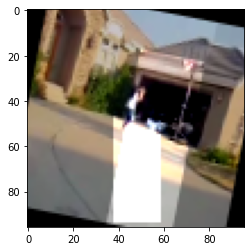

In [141]:
frame, mask = next(train_generator)
plt.imshow(frame)

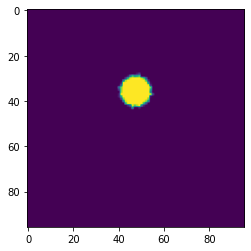

In [142]:
plt.imshow(mask[:,:,2])

## Utils

In [33]:
def get_blob_center(heatmap):
    
    heatmap_size = heatmap.shape[0]
    heatmap = np.abs(heatmap)
    heatmap = heatmap*heatmap*heatmap
    
    dx = np.array(np.arange(0,heatmap_size))
    dx = np.expand_dims(dx,0)
    dx = np.repeat(dx,heatmap_size, axis=0)
    dy = np.rot90(dx, k=3)

    heatmap_dx = dx*heatmap
    heatmap_dy = dy*heatmap
    
    sumed_heatmap = np.sum(heatmap)
    x = np.sum(heatmap_dx)/sumed_heatmap
    y = np.sum(heatmap_dy)/sumed_heatmap
    return np.array([x, y])

def isNaN(num):
    return num != num

def calc_blob_distances(mask_gt, mask_pred):
    distances = []
    for i in range(mask_gt.shape[-1]):
        heatmap_gt, heatmap_pred = mask_gt[:,:,i],mask_pred[:,:,i]
        p_gt = get_blob_center(heatmap_gt)
        p_pred = get_blob_center(heatmap_pred)
        distance = np.linalg.norm(p_gt-p_pred)
        if isNaN(distance):
            distance = None
        distances.append(distance)
    cleaned_distances = [x for x in distances if x != None]
    return cleaned_distances
        
def calc_oks_metric(model_to_eval, val_generator, probes):
    
    x = []
    y_gt = []
    for probe in range(probes):
        x1, y_gt1 = next(val_generator)
        x.append(x1)
        y_gt.append(y_gt1)
    all_frames_distances = []
    y_pred = model_to_eval.predict(np.array(x),verbose = 0)
    for probe in range(probes):
        per_frame_distances = calc_blob_distances(y_gt[probe],y_pred[probe])
        per_frame_distances_avg = np.average(per_frame_distances)
        #print(per_frame_distances_avg)
        all_frames_distances.append(per_frame_distances_avg)
    average_dist = np.average(all_frames_distances)
    return average_dist

In [34]:
history_oks = []

In [35]:
class my_callback(tf.keras.callbacks.Callback):
    def on_epoch_end(self, batch, logs=None):
        train_oks = calc_oks_metric(model_2, train_generator, 500)
        val_oks = calc_oks_metric(model_2, val_generator, 500)
        history_oks.append((train_oks,val_oks))
        print()
        print("train_oks:", train_oks, "val_oks:",val_oks)
        return None

## Model

In [36]:
w_init = tf.keras.initializers.RandomNormal(mean=0.0, stddev=0.02)

In [37]:
def unet_conv(inputs, filters, kernel_size=3, padding="same", strides=2, activation=True):
    x = Conv2D(
        filters=filters,
        kernel_size=kernel_size,
        kernel_initializer=w_init,
        padding=padding,
        strides=strides,
    )(inputs)
    if activation:
        x = BatchNormalization()(x)
        x = ReLU()(x)
        x = Dropout(0.1)(x)
    return x

In [38]:
def unet_up_conv(inputs, filters, kernel_size=3, padding="same", strides=2, activation=True):
    x = Conv2DTranspose(
        filters=filters,
        kernel_size=kernel_size,
        kernel_initializer=w_init,
        padding=padding,
        strides=strides,
        use_bias=True
    )(inputs)
    if activation:
        x = BatchNormalization()(x)
        x = ReLU()(x)
        x = Dropout(0.1)(x)
    return x

In [39]:
def build_generator(img_size=32, num_channels=3):
    
    inputs = keras.Input(shape=(img_size,img_size,num_channels,))
    x1 = unet_conv(inputs, filters = 32, strides = 1)
    
    x2 = unet_conv(x1, filters = 32, strides = 2)
    x3 = unet_conv(x2, filters = 32, strides = 1)
    
    x4 = unet_conv(x3, filters = 64, strides = 2)
    x5 = unet_conv(x4, filters = 64, strides = 1)
    
    x6 = unet_conv(x5, filters = 128, strides = 2)
    x7 = unet_conv(x6, filters = 256, strides = 1)
    
    
    x8 = unet_conv(x7, filters = 512, strides = 2)
    x9 = unet_conv(x8, filters = 512, strides = 1)
    
    x10 = unet_up_conv(x9, filters = 256, strides = 2)
    
    
    x = layers.concatenate([x7, x10])
    x11 = unet_conv(x, filters = 256, strides = 1)
    x12 = unet_up_conv(x11, filters = 256, strides = 2)
    
    x = layers.concatenate([x5, x12])
    x13 = unet_conv(x, filters = 128, strides = 1)
    x14 = unet_up_conv(x13, filters = 128, strides = 2)
    
    x = layers.concatenate([x3, x14])
    x15 = unet_conv(x, filters = 64, strides = 1)
    x16 = unet_up_conv(x15, filters = 64, strides = 2)
    
    x = layers.concatenate([x1, x16, inputs])
    x17 = unet_conv(x, filters = 64, strides = 1)
    
    x = layers.Conv2D(15, kernel_size = 3, padding="same")(x17)
    output = Activation("sigmoid", name="head1")(x)
 
    model = keras.Model(inputs, outputs =  output)
    
    return model
    
    

In [105]:
def build_generator(img_size=32, num_channels=3):
    
    inputs = keras.Input(shape=(img_size,img_size,num_channels,))
    x1 = unet_conv(inputs, filters = 32, strides = 1)
    
    x2 = unet_conv(x1, filters = 32, strides = 2)
    x3 = unet_conv(x2, filters = 32, strides = 1)
    
    x4 = unet_conv(x3, filters = 64, strides = 2)
    x5 = unet_conv(x4, filters = 64, strides = 1)
    
    x6 = unet_conv(x5, filters = 128, strides = 2)
    x7 = unet_conv(x6, filters = 128, strides = 1)
    
    
    x8 = unet_conv(x7, filters = 256, strides = 2)
    x9 = unet_conv(x8, filters = 256, strides = 1)
    
    x10 = unet_up_conv(x9, filters = 256, strides = 2)
    
    
    x = layers.concatenate([x7, x10])
    x11 = unet_conv(x, filters = 256, strides = 1)
    x12 = unet_up_conv(x11, filters = 256, strides = 2)
    
    x = layers.concatenate([x5, x12])
    x13 = unet_conv(x, filters = 128, strides = 1)
    x14 = unet_up_conv(x13, filters = 128, strides = 2)
    
    x = layers.concatenate([x3, x14])
    x15 = unet_conv(x, filters = 64, strides = 1)
    x16 = unet_up_conv(x15, filters = 64, strides = 2)
    
    x = layers.concatenate([x1, x16, inputs])
    x17 = unet_conv(x, filters = 64, strides = 1)
    
    x = layers.Conv2D(15, kernel_size = 3, padding="same")(x17)
    output = Activation("sigmoid", name="head1")(x)

    # Define the model
    model = keras.Model(inputs, outputs = [output])
    
    return model
    
    

In [106]:
model_2 = build_generator(IMG_SIZE)

In [107]:
model_2.summary()

Model: "model_2"
__________________________________________________________________________________________________
 Layer (type)                   Output Shape         Param #     Connected to                     
 input_3 (InputLayer)           [(None, 96, 96, 3)]  0           []                               
                                                                                                  
 conv2d_28 (Conv2D)             (None, 96, 96, 32)   896         ['input_3[0][0]']                
                                                                                                  
 batch_normalization_34 (BatchN  (None, 96, 96, 32)  128         ['conv2d_28[0][0]']              
 ormalization)                                                                                    
                                                                                                  
 re_lu_34 (ReLU)                (None, 96, 96, 32)   0           ['batch_normalization_34[0]

                                                                                                  
 dropout_42 (Dropout)           (None, 6, 6, 256)    0           ['re_lu_42[0][0]']               
                                                                                                  
 conv2d_transpose_8 (Conv2DTran  (None, 12, 12, 256)  590080     ['dropout_42[0][0]']             
 spose)                                                                                           
                                                                                                  
 batch_normalization_43 (BatchN  (None, 12, 12, 256)  1024       ['conv2d_transpose_8[0][0]']     
 ormalization)                                                                                    
                                                                                                  
 re_lu_43 (ReLU)                (None, 12, 12, 256)  0           ['batch_normalization_43[0][0]'] 
          

 conv2d_40 (Conv2D)             (None, 96, 96, 64)   57088       ['concatenate_11[0][0]']         
                                                                                                  
 batch_normalization_50 (BatchN  (None, 96, 96, 64)  256         ['conv2d_40[0][0]']              
 ormalization)                                                                                    
                                                                                                  
 re_lu_50 (ReLU)                (None, 96, 96, 64)   0           ['batch_normalization_50[0][0]'] 
                                                                                                  
 dropout_50 (Dropout)           (None, 96, 96, 64)   0           ['re_lu_50[0][0]']               
                                                                                                  
 conv2d_41 (Conv2D)             (None, 96, 96, 15)   8655        ['dropout_50[0][0]']             
          

In [143]:
class DataGenerator(tf.keras.utils.Sequence):
    def __init__(self, batch_size, gen, size):
        self.batch_size = batch_size
        self.on_epoch_end()
        self.gen = gen
        self.size = size
    def __len__(self):
        return int(self.size/self.batch_size)

    def __getitem__(self, index):
        #index = self.index[index * self.batch_size:(index + 1) * self.batch_size]
        #batch = [self.indices[k] for k in index]
        
        x_train = []
        y_train = []
        for i in range(self.batch_size):
            x, y = next(self.gen)
            x_train.append(x)
            y_train.append(y)
            
        x_train = np.array(x_train)
        y_train = np.array(y_train)
        
        return x_train, y_train

    def on_epoch_end(self):
        pass


In [144]:
tf_train_generator = DataGenerator(batch_size=16, gen=train_generator, size = 640*30/2)
tf_val_generator = DataGenerator(batch_size=16, gen=val_generator, size = 100*30/2)

## Train

In [145]:
opt = tf.keras.optimizers.Adam(learning_rate=0.001)
model_2.compile(optimizer=opt, loss = "mse")

In [146]:
model_2.fit(tf_train_generator, 
            validation_data = tf_val_generator,  
            epochs = 500, batch_size = 16,
           callbacks=[my_callback()]
           )

Epoch 1/500
600/600 [==============================] - ETA: 0s - loss: 0.0098

C:\Users\mati\AppData\Local\Temp\ipykernel_15044\1401431191.py:16: RuntimeWarning: invalid value encountered in double_scalars
  x = np.sum(heatmap_dx)/sumed_heatmap
C:\Users\mati\AppData\Local\Temp\ipykernel_15044\1401431191.py:17: RuntimeWarning: invalid value encountered in double_scalars
  y = np.sum(heatmap_dy)/sumed_heatmap


movies_number 225

train_oks: 11.384076260193961 val_oks: 15.071374847011157
600/600 [==============================] - 68s 109ms/step - loss: 0.0098 - val_loss: 0.0115
Epoch 2/500
600/600 [==============================] - ETA: 0s - loss: 0.0094
train_oks: 11.405123197846251 val_oks: 16.36784346524218
600/600 [==============================] - 63s 105ms/step - loss: 0.0094 - val_loss: 0.0117
Epoch 3/500
600/600 [==============================] - ETA: 0s - loss: 0.0092
train_oks: 13.046041341068129 val_oks: 16.208894310665578
600/600 [==============================] - 62s 103ms/step - loss: 0.0092 - val_loss: 0.0121
Epoch 4/500
157/600 [======>.......................] - ETA: 36s - loss: 0.0091

KeyboardInterrupt: 

In [148]:
train_oks = calc_oks_metric(model_2, train_generator, 500)
val_oks = calc_oks_metric(model_2, val_generator, 500)
print(train_oks,val_oks)

C:\Users\mati\AppData\Local\Temp\ipykernel_15044\1401431191.py:16: RuntimeWarning: invalid value encountered in double_scalars
  x = np.sum(heatmap_dx)/sumed_heatmap
C:\Users\mati\AppData\Local\Temp\ipykernel_15044\1401431191.py:17: RuntimeWarning: invalid value encountered in double_scalars
  y = np.sum(heatmap_dy)/sumed_heatmap


10.37880146591036 16.271608398737555


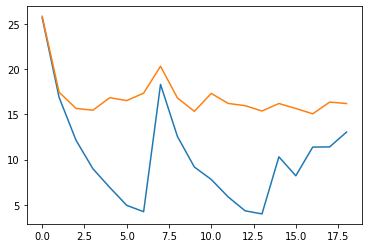

In [149]:
train_oks = [x[0] for x in history_oks]
val_oks = [x[1] for x in history_oks]
plt.plot(train_oks) 
plt.plot(val_oks)
plt.show()

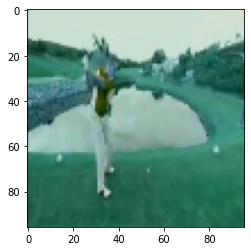

In [182]:
x, y = next(val_generator)
x = np.array(x)
y = np.array(y)
x.shape
plt.imshow(x)

1/1 [==============================] - 0s 21ms/step


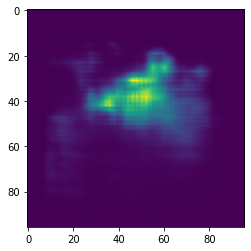

In [183]:
a = model_2.predict(np.array([x]))
a = np.array(a)[0]
plt.imshow(a[:,:,2])

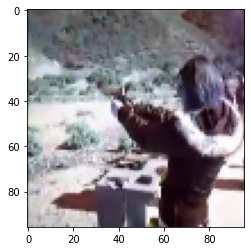

In [50]:
frame = x.copy()
size = 128
plt.imshow(frame)